# What I think needs to be refactored 

- For each of the for statements under the FindLongDataDist function, the logic should be written in a function.
  - Logic within each of the if statement could also be refactored into separate functions, for example, the logic for getting the distribution for discrete variables can be in a separate function, same for logic for getting distribution for any continuous variables.
  - The fitting function from fitter should be adjusted to avoid the excessive printing. Any way for using tqdm here?
  
- The for loop within SimDf should be a separate function

- The SimulateAvailability Function should only produce an availability matrix, rather than concatenate it to the existing long format dataframe


# Importing all necessary packages

In [1]:
import sys
sys.path.append('../../src/')

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
from fitter import Fitter
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import pylogit as pl
from functools import reduce
import seaborn as sns
import random
from scipy import sparse
import copy
from tqdm import tqdm, tqdm_notebook
#import viz
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel

# 0. Rewritten functions (part of refactoring)

In [ ]:
## Functions to replace code within
## FindLongDataDist
## Function for checking length
def isUnique(var_values):
    return len(var_values.unique()) == 1

## Function for checking if variable is categorical
def isCategorical(var_type):
    return var_type == 'categorical'

## Function to get distribution for unique values:
def getConstantDist(ind_var, var_val):
    constant_dict = defaultdict(dict)
    constant_dict[ind_var]['distribution'] = 'constant'
    constant_dict[ind_var]['parameters'] = var_val.unique()
    return constant_dict

## Function to get distribution for categorical variables:
def getCategoricalDist(ind_var, var_val):
    categ_dict = defaultdict(dict)
    categ_dict[ind_var]['distribution'] = 'categorical'
    # Count frequency of values and store it as paramater of distribution
    np_array_range = np.arange(var_val.max()+1)
    array_bincount = np.bincount(var_val)
    probs = array_bincount / len(var_val)
    categ_dict[ind_var]['parameters'] = [np_array_range,
                                      probs]
    return categ_dict


def getContinuousDist(ind_var, var_val, cont_dists):
    cont_dict = defaultdict(dict)    
    fitter_object = Fitter(data=var_val,
                           distributions=cont_dists,
                           timeout=30)
    fitter_object.fit()
    # Get the best distribution and store in dictionary
    BestDict = fitter_object.get_best()
    cont_dict[ind_var]['distribution'] = list(BestDict.items())[0][0]
    cont_dict[ind_var]['parameters'] = list(BestDict.items())[0][1]
    return cont_dict

## Function for looping around individual specific variables
def indSpecDist(data_long, obs_id_col, ind_spec, var_types):
    ind_spec_dict = defaultdict(dict)
    for ind_var in ind_spec:
        # generate array of values for individual specific variable
        var_val = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind_var].unique()[0]) for x in data_long[obs_id_col].unique()])
        var_type = var_types[ind_var]
        # Get distribution if variable is categorical
        if isCategorical(var_type):
            # If only one category
            if isUnique(var_val):
                ind_var_dict = getConstantDist(ind_var, var_val)
            # If more than one category
            else:
                ind_var_dict = getCategoricalDist(ind_var, var_val)
        else:
            ind_var_dict = getContinuousDist(ind_var, var_val, cont_dists)
        ind_spec_dict.update(ind_var_dict)
    return ind_spec_dict

## Functions to replace code for getting
## distributions for alternative specific
## variables

def getConstantDistAlt(alt_var, alt_data, alt_name_dic, alt):
    constant_dict = defaultdict(dict)
    # Add name of alternative to variable and store distriburion & parameters
    constant_dict[alt_var+'_'+alt_name_dic[alt]]['distribution'] = 'constant'
    constant_dict[alt_var+'_'+alt_name_dic[alt]]['parameters'] = alt_data[alt_var].unique()
    return constant_dict

def getCategoricalDistAlt(alt_var, alt_data, alt_name_dic, alt):
    categ_dict = defaultdict(dict)
    categ_dict[alt_var+'_'+alt_name_dic[alt]]['distribution'] = 'categorical'
    np_array_range = np.arange(alt_data[alt_var].max()+1)
    array_bincount = np.bincount(alt_data[alt_var])
    probs = array_bincount / len(alt_data[alt_var])
    categ_dict[alt_var+'_'+alt_name_dic[alt]]['parameters'] = [np_array_range,
                                                               probs]
    return categ_dict

def getContinuousDistAlt(alt_var, alt_data, alt_name_dic, alt):
    cont_dict = defaultdict(dict)
    # Use the Fitter library to fit distributions
    # to the data
    fitter_object = Fitter(data=alt_data[alt_var],
                           distributions=cont_dists,
                           timeout=30)
    fitter_object.fit()
    # Get the best distribution and store in dictionary
    BestDict = fitter_object.get_best()
    # Add name of alternative to variable and store distriburion & parameters
    cont_dict[alt_var+'_'+alt_name_dic[alt]]['distribution'] = list(BestDict.items())[0][0]
    cont_dict[alt_var+'_'+alt_name_dic[alt]]['parameters'] = list(BestDict.items())[0][1]
    return cont_dict
    

# Code for Alternative Specific Variables
# Loop around the different available alternatives
def altSpecDist(data_long, alt_id_col, alt_spec, var_types, alt_name_dic):
    all_alt_spec_var_dic = defaultdict(dict)
    for alt in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        alt_data = data_long.loc[data_long['mode_id'] == alt]
        alt_spec_dic = defaultdict(dict)
        # Loop around the alternative specific
        # variables in the input dictionary
        for alt_var in alt_spec:
            var_type = var_types[alt_var]
            # If data is categorical
            if isCategorical(var_type):
                # If only one category
                if isUnique(alt_data[alt_var]):
                    # Add name of alternative to variable
                    # and store distriburion & parameters
                    alt_spec_var_dic = getConstantDistAlt(alt_var, alt_data, alt_name_dic, alt)
                else:
                    # If more than one category, compute
                    # the frequency of values and store
                    # as parameters
                    # Add name of alternative to variable
                    # and store distriburion & parameters
                    alt_spec_var_dic = getCategoricalDistAlt(alt_var, alt_data, alt_name_dic, alt)
            else:
                # If data is not categorical but has one unique value
                if isUnique(alt_data[alt_var]):
                    alt_spec_var_dic = getConstantDistAlt(alt_var, alt_data, alt_name_dic, alt)
                # If data is not categorical but has more than one unique value
                else:
                    alt_spec_var_dic = getContinuousDistAlt(alt_var, alt_data, alt_name_dic, alt)
            alt_spec_dic.update(alt_spec_var_dic)
        all_alt_spec_var_dic.update(alt_spec_dic)
    return all_alt_spec_var_dic

##############################################################
##############################################################

# Code for Trip Specific Variables
# Loop around the different available alternatives
def tripSpecDist():
    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    trip_spec_dict = defaultdict(dict)
    for trip_var in trip_spec:
        # generate array of values for trip specific variable
        trip_var_data = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
        # Get distribution if variable is categorical
        var_type = var_types[trip_var]
        if isCategorical(var_type):
            if isUnique(trip_var_data):
            # If only one category
                trip_spec_var_dic = getConstantDist(trip_var, trip_var_data)
            else:
            # If more than one category
                trip_spec_var_dic = getCategoricalDist(trip_var, trip_var_data)
        else:
            # If not categorical but just one unique value
            if lisUnique(trip_var_data):
                trip_spec_var_dic = getConstantDist(trip_var, trip_var_data)
            # If not categorical but just one unique value
            else:
                trip_spec_var_dic = getContinuousDist(trip_var, trip_var_data, cont_dists)
        trip_spec_dict.update(trip_spec_var_dic)
    return trip_spec_dict

##############################################################
##############################################################

# 1. Define Necessary Functions

In [215]:


def FindLongDataDist(data_long,
                     alt_id_col,
                     obs_id_col,
                     alt_spec,
                     alt_name_dic,
                     ind_spec,
                     trip_spec,
                     var_types,
                     cont_dists=None):
    
    """
    Function to find the distribution of specific variables
    from a long format dataset.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Dataset in long format from which variable
        distribution is to be found.
        
    alt_id_col: string
        Name of the column with alternative ids.
        
    obs_id_col: string
        Name of the column with observation ids.
        
    alt_spec: list
        List containing strings of the names of
        alternative specific variables.
        
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    ind_spec: list
        List containing strings of the names of 
        individual specific variables.
        
    trip_spec: list
        List containing string of the names of 
        trip specific variables.
        
    var_types: dictionary
        Dictionary with keys as strings of names of variables
        from long format dataset, and values for each key are
        the type of variables (e.g.: 'categorical vs. continuous').
        
    cont_dists: list
        List of continuous RVs distribution names from scipy.
        
    Returns
    -------
    a nested dictionary with keys as variable names and values
    as dictionaries containing both the distribution name and
    its parameters.
    """

    # Initialize the output parameters dictionary
    params_dict = defaultdict(dict)

    # Loop around individual specific variables
    for ind in ind_spec:
        # generate array of values for individual specific variable
        ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])
        # Get distribution if variable is categorical
        var_type = var_types[ind]
        if var_type == 'categorical':
            # If only one category
            if len(ind_var.unique()) == 1:
                params_dict[ind]['distribution'] = 'constant'
                params_dict[ind]['parameters'] = ind_var.unique()
            # If more than one category
            else:
                params_dict[ind]['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(ind_var.max()+1)
                array_bincount = np.bincount(ind_var)
                probs = array_bincount / len(ind_var)
                params_dict[ind]['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(ind_var.unique()) == 1:
                params_dict[ind]['distribution'] = 'constant'
                params_dict[ind]['parameters'] = ind_var.unique()
            # If not categorical but not one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=ind_var,
                                       distributions=cont_dists,
                                       timeout=30)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict[ind]['distribution'] = list(BestDict.items())[0][0]
                params_dict[ind]['parameters'] = list(BestDict.items())[0][1]

    # Code for Alternative Specific Variables
    # Loop around the different available alternatives
    for alt in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        mode_data = data_long.loc[data_long['mode_id'] == alt]
        # Loop around the alternative specific variables in the input dictionary
        for var in alt_spec:
            # If data is categorical
            if var_types[var] == 'categorical':
                # If only one category
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict[var+'_'+alt_name_dic[alt]]['distribution'] = 'constant'
                    params_dict[var+'_'+alt_name_dic[alt]]['parameters'] = mode_data[var].unique()
                else:
                    # If more than one category, compute the frequency of values
                    # and store as parameters
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict[var+'_'+alt_name_dic[alt]]['distribution'] = 'categorical'
                    np_array_range = np.arange(mode_data[var].max()+1)
                    array_bincount = np.bincount(mode_data[var])
                    probs = array_bincount / len(mode_data[var])
                    params_dict[var+'_'+alt_name_dic[alt]]['parameters'] = [np_array_range,
                                                                            probs]
            else:
                # If data is not categorical but has one unique value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict[var+'_'+alt_name_dic[alt]]['distribution'] = 'constant'
                    params_dict[var+'_'+alt_name_dic[alt]]['parameters'] = mode_data[var].unique()
                # If data is not categorical but has more than one unique value
                else:
                    # Use the Fitter library to fit distributions
                    # to the data
                    fitter_object = Fitter(data=mode_data[var],
                                           distributions=cont_dists,
                                           timeout=30)
                    fitter_object.fit()
                    # Get the best distribution and store in dictionary
                    BestDict = fitter_object.get_best()
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict[var+'_'+alt_name_dic[alt]]['distribution'] = list(BestDict.items())[0][0]
                    params_dict[var+'_'+alt_name_dic[alt]]['parameters'] = list(BestDict.items())[0][1]

    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    for var in trip_spec:
        # generate array of values for trip specific variable
        trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
        # Get distribution if variable is categorical
        if var_types[var] == 'categorical':
            if len(trip_var.unique()) == 1:
            # If only one category
                params_dict[var]['distribution'] = 'constant'
                params_dict[var]['parameters'] = trip_var.unique()
            else:
            # If more than one category
                params_dict[var]['distribution'] = 'categorical'
            # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(trip_var.max()+1)
                array_bincount = np.bincount(trip_var)
                probs = array_bincount / len(trip_var)
                params_dict[var]['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(trip_var.unique()) == 1:
                params_dict[var]['distribution'] = 'constant'
                params_dict[var]['parameters'] = trip_var.unique()
            # If not categorical but just one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=trip_var,
                                       distributions=cont_dists,
                                       timeout=30)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict[var]['distribution'] = list(BestDict.items())[0][0]
                params_dict[var]['parameters'] = list(BestDict.items())[0][1]

    return params_dict


def SimDf(params_dict, size=1000):
    """
    Funtion to simulate data of size N based on specified
    distribution/parameters found by the fitter package.
    
    Paremeters
    ----------
    dist_params: dictionary
        The variable distribution dictionary resulting from
        `FindLongDataDist`.
        
    size: int
        Size of the desired simulated dataset, default value
        is 1000 observations.
    
    Returns
    -------
    DataFrame object with simulated data based on specified distributions
    
    """
    # Create Empty DataFrame with keys from params_dict
    Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
    Sim_Df = Sim_Df.fillna(0)
    
    # Loop around each of the variables in params_dict
    # and simulate data for them
    for column in list(params_dict.keys()):
        if params_dict[column]['distribution'] == 'categorical':
            data_sim = np.random.choice(a=params_dict[column]['parameters'][0],
                                        p=params_dict[column]['parameters'][1],
                                        size=size)
            Sim_Df[column] = data_sim
        elif params_dict[column]['distribution'] == 'constant':
            data_sim = params_dict[column]['parameters'][0]
            Sim_Df[column] = data_sim
        else:
            dist = getattr(scipy.stats, params_dict[column]['distribution'])
            data_sim = dist.rvs(*params_dict[column]['parameters'], size=size)
            Sim_Df[column] = data_sim
    return Sim_Df

def FindOutliers(data, threshold=3.5):
    """
    Function to remove outlier data, based on
    the median absolute deviation from the median.
    Note that the function supports asymmetric 
    distributions and is based on code from the
    included reference
    
    Parameters
    ----------
    data: Pandas Series-line
        Series-like containing the simulated
        data in wide format.
        
    threshold: float
        Threshold of the Median Absolute Deviation
        above which data should be removed
        
    Returns
    -------
    Array with True values representing index
    of non-outliers
    
    References
    ----------
    https://eurekastatistics.com/using-the-median-
    absolute-deviation-to-find-outliers/
    
    TODO:
    -----
    We need to discuss whether this approach is 
    appropriate for dropping outlier observations
    """
    
    m = np.median(data)
    abs_dev = np.abs(data - m)
    left_mad = np.median(abs_dev[data <= m])
    right_mad = np.median(abs_dev[data >= m])
    data_mad = left_mad * np.ones(len(data))
    data_mad[data > m] = right_mad
    z_score = abs_dev / data_mad
    z_score[data == m] = 0
    return z_score < threshold


def SimulateAvailability(data_long, sim_size, obs_id_col, alt_name_dict):
    
    """
    Function to simulate alternative availability based on a long format
    dataset and join the availability data to the simulated dataset
    resulting from SimDf.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Long format dataframe used for simulating
        alternative availability.
    
    obs_id_col: string
        Name of the column in data_long with 
        observation ids.
    
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    Returns
    -------
    Wide format Pandas DataFrame with additional availability
    columns for each of the alternatives.
    
    """

    # Create empty Series to hold number of available alternatives
    series = pd.Series([])
    
    # Loop around each observation to record the
    # available number of alternatives for each observation
    for i, obs in zip(np.arange(len(data_long[obs_id_col].unique())), data_long[obs_id_col].unique()):
        series[i] = data_long[data_long[obs_id_col] == obs].shape[0]

    # Simulate number of available alternatives for
    # each observation in sim_data
    av_size = sim_size
    alts_sim = np.random.choice(a=np.arange(series.max()+1),
                                p=np.bincount(series)/len(series),
                                size=av_size)

    # simulate the availability matrix based on number 
    # of available alternatives
    N = len(alt_name_dict)
    av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]

    # Shuffle the available alternatives for each observation
    # because av_sim will always start with 1s
    for x in av_sim:
        np.random.shuffle(x)

    # Shuffle the availability across different observations
    np.random.shuffle(av_sim)
    
    # Create columns for the availability matrix
    AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]
    
    # Create alternative availability matrix with AV_columns
    AV_Df = pd.DataFrame(av_sim, columns=AV_columns)
    
    # Create an random choice column based on available
    # alternatives for each observation - This column will
    # be needed when converting to long data -- this will
    # be moved to a different column
    fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_Df)]
    fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])
    
    # Concatenate the simulated data with availability data and fake choice data
    # and return Sim_DF_AV
    Sim_DF_AV = pd.concat([AV_Df, fake_choice_df], axis=1, sort=False)
    return Sim_DF_AV

def PlotParams(sim_par, model, fig_size):
    """
    Function to plot parameters from simulated data.
    
    Parameters
    ----------
    sim_par: Pandas Series or Pandas Column
        Pandas Series or column from DataFrame containing
        coefficients from the estimated models based on
        simulated data.
        
    model: Pylogit model.
        Estimated data generating model to compare 
        estimated parameters based on simulated data
        to.
        
    size: tuple
        Figure size
        
    Returns
    -------
    Seaborn figure of the distribution of estimated parameters
    based on simulated data.
    """
    # Create bins for the histogram
    bins = np.linspace(sim_par.min(), sim_par.max(), 10)
    
    # Initialize the figure size
    plt.figure(figsize=fig_size)
    
    # Plot the distribution
    sns.distplot(sim_par, kde=False, bins=bins, label='Simulated Parameters')
    
    # Add vertical line for the data generating parameter
    plt.axvline(model.coefs[sim_par.name], color='black', ls='--',label='Data Generating Parameter')
    
    # Add a title for the figure
    plt.title(label='Histogram of '+'"'+sim_par.name+'"', fontdict={'fontsize':16})
    
    # Add a y-label
    plt.ylabel('Frequency', rotation=0, labelpad=50)
    
    # Add a legend
    plt.legend()

# 2. Example using bike data 

## 2.1. Data Ingestion and Exploration 

In [16]:
# Create a variable for the path to the long format data for
# the multinomial choice model
PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [17]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [18]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## 2.2. MNL Model Specification and Estimation

In [19]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

In [20]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Sat, 28 Mar 2020   Pseudo R-squ.:                   0.332
Time:                             14:46:30   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

## 3. Example Simulation Implementation 

## 3.1. Declaring variables

In [21]:
# Declaring all the needed variables for each of our functions

# Observation id column
observation_id_col = 'observation_id'

# Alternative id column
alternative_id_col = 'mode_id'

# Individual specific variables list
individual_specific_variables = ['num_kids', 'household_size',
                                 'num_cars', 'num_licensed_drivers']

# Alternative specific variables list
alternative_specific_variables = ['total_travel_time',
                                  'total_travel_distance',
                                  'total_travel_cost']

# Trip specific variables list
trip_specific_variables = ['cross_bay']

# Alternative name dictionary
alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

# Variable type Dictionary
variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

## 3.2. Find Distributions of Variables

In [22]:
# Generate a parameters dictionary from long
# format data
bike_data_params = FindLongDataDist(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec=alternative_specific_variables,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                    cont_dists=distributions)

SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.0007989652291582563)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.00021837510493444555)
Fitted gamma distribution with error=0.00021215664843294874)
Fitted expon distribution with error=0.00042675380208476757)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.014522128648725777)
Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.013034447497270776)
Fitted beta distribution with error=0.04104766585766829)
Fitted gamma distribution with error=0.03662007898297577)
Fitted expon distribution with error=0.07921887555564106)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
F

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=8.724425966292245)
Fitted gamma distribution with error=8.724370722136563)
Fitted expon distribution with error=9.1690513221318)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=6.672556141363111e-05)
Fitted beta distribution with error=6.196777802352273e-05)
Fitted gamma distribution with error=6.08535018564024e-05)
Fitted expon distribution with error=0.0007188034183935458)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=8.324919501617495)
Fitted beta distribution with error=9.381940852860888)
Fitted gamma distribution with error=8.638629330672966)
Fitted expon distribution with error=9.271523141699383)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution 

## 3.3. Simulate Data based on Distributions

In [23]:
# Simulate data from the params_dict
wide_sim_data = SimDf(params_dict=bike_data_params, size=2000)

In [24]:
# Explore the simulated data
wide_sim_data.head()

,num_kids,household_size,num_cars,num_licensed_drivers,total_travel_time_drive_alone,total_travel_distance_drive_alone,total_travel_cost_drive_alone,total_travel_time_shared_2,total_travel_distance_shared_2,total_travel_cost_shared_2,...,total_travel_time_wtd,total_travel_distance_wtd,total_travel_cost_wtd,total_travel_time_walk,total_travel_distance_walk,total_travel_cost_walk,total_travel_time_bike,total_travel_distance_bike,total_travel_cost_bike,cross_bay
0,1,4.0,4.0,2.0,33.972564,11.428639,1.518184,26.480314,2.058284,0.238499,...,31.388420,0.0,3.308575,149.761074,3.098948,0.0,10.332849,4.210567,0.0,0
1,2,3.0,2.0,2.0,10.334369,2.437344,16.061607,4.475864,2.367844,2.109127,...,111.710137,0.0,3.432111,6.357895,20.923257,0.0,84.655317,3.058294,0.0,0
2,0,1.0,0.0,2.0,6.382982,6.575625,2.466521,27.870336,15.888555,1.849838,...,28.073314,0.0,3.581858,536.775151,2.162068,0.0,22.727780,2.801392,0.0,0
3,1,3.0,2.0,2.0,18.781632,1.639680,3.970611,58.411573,9.535244,0.519312,...,59.326685,0.0,3.616163,35.758960,3.648791,0.0,10.324041,3.426759,0.0,0
4,0,4.0,1.0,2.0,7.701396,6.514081,1.466105,8.019330,4.044991,0.127192,...,181.379615,0.0,3.378018,618.518525,37.759582,0.0,164.606269,52.288174,0.0,0


## 3.4. Simulate Availability 

In [25]:
# Simulate availability, add fake choice column
# and return final simulated data with availability
# and choices

wide_sim_data_availability = SimulateAvailability(bike_data_long,
                                     sim_data=wide_sim_data,
                                     obs_id_col=observation_id_col,
                                     alt_name_dict=alternative_name_dict)

## 3.5. Simulate Choices 

### 3.5.1. Convert Simulated Data from Wide to Long 

In [26]:
ind_variables = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']


# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd'),
                                                     (7, 'total_travel_time_walk'),
                                                     (8, 'total_travel_time_bike')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd'),
                                                     (7, 'total_travel_cost_walk'),
                                                     (8, 'total_travel_cost_bike')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (4, 'total_travel_distance_wtw'),
                                                         (5, 'total_travel_distance_dtw'),
                                                         (6, 'total_travel_distance_wtd'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')]),
                            }


# Dictionary of alternative availability variables
availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "observation_id"

wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data.shape[0],
                                         dtype=int) + 1


# Create an empty choice column
choice_column = "sim_choice"

### 3.5.2. Convert to Long Format Data

In [27]:
# Convert data from wide to long
long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)

In [28]:
# Create a cars per licensed drivers column
long_sim_data["cars_per_licensed_drivers"] = 0
long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                  "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

In [29]:
# Add a variable representing cost divided by distance
long_sim_data["cost_per_distance"] = 0
long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                  "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_cost"] /
                                          long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_distance"])

### 3.5.3. Simulate choices

In [30]:
# Calculate probabilities for each alternative
# based on the estimated model
posterior_probs = mnl_model.predict(long_sim_data)

# Simulate choice data
long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


## 3.6. Estimate the model based on simulate choice data 

In [31]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                       alt_id_col="mode_id",
                                       obs_id_col="observation_id",
                                       choice_col="sim_choice",
                                       specification=mnl_specification,
                                       model_type="MNL",
                                       names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model_sim.fit_mle(np.zeros(num_vars),
                      method="BFGS")

# Look at the estimation results
mnl_model_sim.get_statsmodels_summary()

Log-likelihood at zero: -3,794.3389
Initial Log-likelihood: -3,794.3389


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -1,305.5466


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                2,000
Model:             Multinomial Logit Model   Df Residuals:                    1,981
Method:                                MLE   Df Model:                           19
Date:                     Sat, 28 Mar 2020   Pseudo R-squ.:                   0.656
Time:                             14:47:42   Pseudo R-bar-squ.:               0.651
AIC:                             2,649.093   Log-Likelihood:             -1,305.547
BIC:                             2,755.510   LL-Null:                    -3,794.339
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.2303      0.257     -4.783      0.000      -1.734      -0.726
ASC Shared Ride: 3+                                      3.4616      0.305     11.352      0.000       2.864       4.059
ASC Walk-Transit-Walk                                   -0.2337      0.323     -0.724      0.469      -0.866       0.399
ASC Drive-Transit-Walk                                  -2.8430      0.342     -8.306      0.000      -3.514      -2.172
ASC Walk-Transit-Drive                                  -2.9144      0.340     -8.580      0.000      -3.580      -2.249
ASC Walk                                                 1.2326      0.274      4.502      0.000       0.696       1.769
ASC Bike                                                -1.3556      0.231     -5.862      0.000      -1.809      -0.902
Travel Time, units:min (All Auto Modes)                 -0.0788      0.004    -20.020      0.000      -0.086      -0.071
Travel Time, units:min (All Transit Modes)              -0.0274      0.003    -10.089      0.000      -0.033      -0.022
Travel Cost, units:$ (All Transit Modes)                -0.1358      0.037     -3.678      0.000      -0.208      -0.063
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.6972      0.475    -12.006      0.000      -6.627      -4.767
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.6311      1.777    -11.612      0.000     -24.113     -17.149
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.4695      4.960    -18.240      0.000    -100.191     -80.748
Autos per licensed drivers (All Auto Modes)              1.3389      0.131     10.194      0.000       1.081       1.596
Travel Distance, units:mi (Walk)                        -0.9711      0.071    -13.736      0.000      -1.110      -0.833
Travel Distance, units:mi (Bike)                        -0.2836      0.033     -8.660      0.000      -0.348      -0.219
Cross-Bay Tour (Shared Ride 2 & 3+)                      1.3376      0.342      3.912      0.000       0.668       2.008
Household Size (Shared Ride 2 & 3+)                      0.1327      0.056      2.373      0.018       0.023       0.242
Number of Kids in Household (Shared Ride 2 & 3+)         0.6817      0.074      9.198      0.000       0.536       0.827
========================================================================================================================
"""

# 4. Repeat simulation many times 

### 4.1. Set up all needed variables

In [32]:
observation_id_col = 'observation_id'

alternative_id_col = 'mode_id'

variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical'}

individual_specific_variables = ['num_kids', 'household_size',
                                 'num_cars', 'num_licensed_drivers']

alternative_specific_variables = ['total_travel_time', 'total_travel_distance', 'total_travel_cost']

trip_specific_variables = ['cross_bay']

alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

choice_column = "sim_choice"

custom_alt_id = "mode_id"

alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd'),
                                                     (7, 'total_travel_time_walk'),
                                                     (8, 'total_travel_time_bike')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd'),
                                                     (7, 'total_travel_cost_walk'),
                                                     (8, 'total_travel_cost_bike')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (4, 'total_travel_distance_wtw'),
                                                         (5, 'total_travel_distance_dtw'),
                                                         (6, 'total_travel_distance_wtd'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')]),
                        }


availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

bike_data_params = FindLongDataDist(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec=alternative_specific_variables,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                    cont_dists=distributions)

SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.0007989652291582563)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.00021837510493444555)
Fitted gamma distribution with error=0.00021215664843294874)
Fitted expon distribution with error=0.00042675380208476757)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.014522128648725777)
Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.013034447497270776)
Fitted beta distribution with error=0.04104766585766829)
Fitted gamma distribution with error=0.03662007898297577)
Fitted expon distribution with error=0.07921887555564106)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
F

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=8.724425966292245)
Fitted gamma distribution with error=8.724370722136563)
Fitted expon distribution with error=9.1690513221318)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=6.672556141363111e-05)
Fitted beta distribution with error=6.196777802352273e-05)
Fitted gamma distribution with error=6.08535018564024e-05)
Fitted expon distribution with error=0.0007188034183935458)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=8.324919501617495)
Fitted beta distribution with error=9.381940852860888)
Fitted gamma distribution with error=8.638629330672966)
Fitted expon distribution with error=9.271523141699383)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution 

## 4.2. Simulate and Estimate models N times

In [35]:
simulation_size = np.random.randint(low=4000, high=8000, size=100)
sim_number = np.arange(1,101)
models_dictionary = defaultdict(dict)

for size, number in zip(simulation_size, sim_number):
    print('Simulation number', number , 'is in process...')
    print('------------------------------------------')

    # Simulate data from the params_dict
    wide_sim_data = SimDf(params_dict=bike_data_params,
                     size = size)

    # Simulate availability based on availability 
    # from long data and addd a fake choice column
    wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long, 
                                         sim_data=wide_sim_data, 
                                         obs_id_col=observation_id_col, 
                                         alt_name_dict=alternative_name_dict)

    # Add an observation_id column
    wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                            dtype=int) + 1
    
    # Convert simulated data from wide to long
    long_sim_data = pl.convert_wide_to_long(wide_data=wide_sim_data_availability,
                                            ind_vars=ind_variables, 
                                            alt_specific_vars=alt_varying_variables, 
                                            availability_vars=availability_variables,
                                            obs_id_col=observation_id_col,
                                            choice_col=choice_column,
                                            new_alt_id_name=custom_alt_id)
    
    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                      "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                      "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_cost"] /
                                              long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                        "total_travel_distance"])
    
    # Calculate posterior probabilities for each alternative
    posterior_probs = mnl_model.predict(long_sim_data)

    # Simulate choices based on calculated probabilities
    long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                                                         long_sim_data['observation_id'].values)

    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

    num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
    
    # Note newton-cg used to ensure convergence to a point where gradient 
    # is essentially zero for all dimensions. 
    mnl_model_sim.fit_mle(np.zeros(num_vars),
                          method="BFGS")

    # Store model
    models_dictionary[number] = mnl_model_sim
    
    print('Simulation number', number , 'is complete!')
    print('==========================================')
    print('==========================================')

Simulation number 1 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,071.4280
Initial Log-likelihood: -10,071.4280


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.79 seconds.
Final log-likelihood: -3,467.1350
Simulation number 1 is complete!
Simulation number 2 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,173.4263
Initial Log-likelihood: -11,173.4263


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.64 seconds.
Final log-likelihood: -3,878.1213
Simulation number 2 is complete!
Simulation number 3 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,880.8791
Initial Log-likelihood: -14,880.8791


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.76 seconds.
Final log-likelihood: -5,106.8676
Simulation number 3 is complete!
Simulation number 4 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,637.2007
Initial Log-likelihood: -11,637.2007


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.86 seconds.
Final log-likelihood: -4,071.2502
Simulation number 4 is complete!
Simulation number 5 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,362.3794
Initial Log-likelihood: -11,362.3794


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.77 seconds.
Final log-likelihood: -4,035.7805
Simulation number 5 is complete!
Simulation number 6 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,794.9213
Initial Log-likelihood: -13,794.9213


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 1.05 seconds.
Final log-likelihood: -4,772.1948
Simulation number 6 is complete!
Simulation number 7 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,411.4703
Initial Log-likelihood: -8,411.4703


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.94 seconds.
Final log-likelihood: -2,878.9047
Simulation number 7 is complete!
Simulation number 8 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,299.7612
Initial Log-likelihood: -13,299.7612


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.76 seconds.
Final log-likelihood: -4,567.1352
Simulation number 8 is complete!
Simulation number 9 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,262.1307
Initial Log-likelihood: -11,262.1307


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.70 seconds.
Final log-likelihood: -3,910.5328
Simulation number 9 is complete!
Simulation number 10 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,649.5112
Initial Log-likelihood: -9,649.5112


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -3,455.5291
Simulation number 10 is complete!
Simulation number 11 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,920.0447
Initial Log-likelihood: -9,920.0447


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.78 seconds.
Final log-likelihood: -3,443.6809
Simulation number 11 is complete!
Simulation number 12 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,301.4600
Initial Log-likelihood: -9,301.4600


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -3,203.2551
Simulation number 12 is complete!
Simulation number 13 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,556.6718
Initial Log-likelihood: -11,556.6718


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.92 seconds.
Final log-likelihood: -4,051.4673
Simulation number 13 is complete!
Simulation number 14 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,261.5069
Initial Log-likelihood: -8,261.5069


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -2,900.7070
Simulation number 14 is complete!
Simulation number 15 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,743.6321
Initial Log-likelihood: -10,743.6321


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.75 seconds.
Final log-likelihood: -3,805.5994
Simulation number 15 is complete!
Simulation number 16 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,716.8233
Initial Log-likelihood: -13,716.8233


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.94 seconds.
Final log-likelihood: -4,693.0984
Simulation number 16 is complete!
Simulation number 17 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,043.0579
Initial Log-likelihood: -14,043.0579


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.53 seconds.
Final log-likelihood: -4,896.2772
Simulation number 17 is complete!
Simulation number 18 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,863.8053
Initial Log-likelihood: -11,863.8053


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.68 seconds.
Final log-likelihood: -4,076.2789
Simulation number 18 is complete!
Simulation number 19 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,148.8626
Initial Log-likelihood: -15,148.8626


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.68 seconds.
Final log-likelihood: -5,173.4798
Simulation number 19 is complete!
Simulation number 20 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,862.4576
Initial Log-likelihood: -9,862.4576


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,369.7848
Simulation number 20 is complete!
Simulation number 21 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,569.7788
Initial Log-likelihood: -9,569.7788


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -3,308.3564
Simulation number 21 is complete!
Simulation number 22 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,057.0280
Initial Log-likelihood: -8,057.0280


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.32 seconds.
Final log-likelihood: -2,844.9553
Simulation number 22 is complete!
Simulation number 23 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,117.5263
Initial Log-likelihood: -13,117.5263


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.63 seconds.
Final log-likelihood: -4,585.5513
Simulation number 23 is complete!
Simulation number 24 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,363.1180
Initial Log-likelihood: -10,363.1180


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,563.8862
Simulation number 24 is complete!
Simulation number 25 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,846.1815
Initial Log-likelihood: -11,846.1815


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -4,116.9021
Simulation number 25 is complete!
Simulation number 26 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,186.6176
Initial Log-likelihood: -11,186.6176


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -3,891.8552
Simulation number 26 is complete!
Simulation number 27 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,730.3187
Initial Log-likelihood: -14,730.3187


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.86 seconds.
Final log-likelihood: -5,079.5510
Simulation number 27 is complete!
Simulation number 28 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,956.2843
Initial Log-likelihood: -12,956.2843


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.93 seconds.
Final log-likelihood: -4,580.4238
Simulation number 28 is complete!
Simulation number 29 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,352.3155
Initial Log-likelihood: -9,352.3155


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -3,282.4942
Simulation number 29 is complete!
Simulation number 30 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,273.8419
Initial Log-likelihood: -9,273.8419


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -3,201.7640
Simulation number 30 is complete!
Simulation number 31 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,104.2362
Initial Log-likelihood: -14,104.2362


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.88 seconds.
Final log-likelihood: -4,835.1214
Simulation number 31 is complete!
Simulation number 32 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,188.3261
Initial Log-likelihood: -9,188.3261


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -3,202.0376
Simulation number 32 is complete!
Simulation number 33 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,530.7030
Initial Log-likelihood: -9,530.7030


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -3,297.5407
Simulation number 33 is complete!
Simulation number 34 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,874.3037
Initial Log-likelihood: -9,874.3037


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -3,351.9303
Simulation number 34 is complete!
Simulation number 35 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,979.3625
Initial Log-likelihood: -13,979.3625


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.58 seconds.
Final log-likelihood: -4,742.5635
Simulation number 35 is complete!
Simulation number 36 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,757.2108
Initial Log-likelihood: -14,757.2108


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.61 seconds.
Final log-likelihood: -5,036.4901
Simulation number 36 is complete!
Simulation number 37 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,295.6426
Initial Log-likelihood: -10,295.6426


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -3,638.4819
Simulation number 37 is complete!
Simulation number 38 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,478.0847
Initial Log-likelihood: -14,478.0847


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.67 seconds.
Final log-likelihood: -5,084.1134
Simulation number 38 is complete!
Simulation number 39 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,462.1362
Initial Log-likelihood: -14,462.1362


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.73 seconds.
Final log-likelihood: -5,092.5991
Simulation number 39 is complete!
Simulation number 40 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,601.5773
Initial Log-likelihood: -9,601.5773


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,346.5317
Simulation number 40 is complete!
Simulation number 41 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,399.4116
Initial Log-likelihood: -11,399.4116


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -3,922.1934
Simulation number 41 is complete!
Simulation number 42 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,604.8068
Initial Log-likelihood: -9,604.8068


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -3,386.0007
Simulation number 42 is complete!
Simulation number 43 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,771.6407
Initial Log-likelihood: -13,771.6407


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.58 seconds.
Final log-likelihood: -4,693.5845
Simulation number 43 is complete!
Simulation number 44 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,421.5973
Initial Log-likelihood: -11,421.5973


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.55 seconds.
Final log-likelihood: -3,858.8215
Simulation number 44 is complete!
Simulation number 45 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,095.4383
Initial Log-likelihood: -10,095.4383


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -3,531.5890
Simulation number 45 is complete!
Simulation number 46 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,629.1940
Initial Log-likelihood: -12,629.1940


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -4,389.9434
Simulation number 46 is complete!
Simulation number 47 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,185.3202
Initial Log-likelihood: -15,185.3202


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.67 seconds.
Final log-likelihood: -5,239.1424
Simulation number 47 is complete!
Simulation number 48 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,966.3355
Initial Log-likelihood: -11,966.3355


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.53 seconds.
Final log-likelihood: -4,214.0704
Simulation number 48 is complete!
Simulation number 49 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,041.6450
Initial Log-likelihood: -12,041.6450


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.72 seconds.
Final log-likelihood: -4,157.9397
Simulation number 49 is complete!
Simulation number 50 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,215.1703
Initial Log-likelihood: -14,215.1703


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.62 seconds.
Final log-likelihood: -4,818.2202
Simulation number 50 is complete!
Simulation number 51 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,407.9514
Initial Log-likelihood: -12,407.9514


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.82 seconds.
Final log-likelihood: -4,347.8106
Simulation number 51 is complete!
Simulation number 52 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,537.7942
Initial Log-likelihood: -12,537.7942


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.61 seconds.
Final log-likelihood: -4,215.9246
Simulation number 52 is complete!
Simulation number 53 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,708.1486
Initial Log-likelihood: -10,708.1486


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -3,758.2579
Simulation number 53 is complete!
Simulation number 54 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,183.2340
Initial Log-likelihood: -15,183.2340


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.75 seconds.
Final log-likelihood: -5,145.4159
Simulation number 54 is complete!
Simulation number 55 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,196.6976
Initial Log-likelihood: -13,196.6976


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.62 seconds.
Final log-likelihood: -4,450.6638
Simulation number 55 is complete!
Simulation number 56 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,937.6232
Initial Log-likelihood: -9,937.6232


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -3,396.7462
Simulation number 56 is complete!
Simulation number 57 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,280.1577
Initial Log-likelihood: -10,280.1577


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -3,539.3982
Simulation number 57 is complete!
Simulation number 58 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,166.0699
Initial Log-likelihood: -15,166.0699


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.64 seconds.
Final log-likelihood: -5,299.4683
Simulation number 58 is complete!
Simulation number 59 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,777.4457
Initial Log-likelihood: -8,777.4457


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -3,011.9011
Simulation number 59 is complete!
Simulation number 60 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,547.7633
Initial Log-likelihood: -12,547.7633


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.67 seconds.
Final log-likelihood: -4,363.9379
Simulation number 60 is complete!
Simulation number 61 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,077.1043
Initial Log-likelihood: -11,077.1043


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -3,901.2142
Simulation number 61 is complete!
Simulation number 62 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,422.5692
Initial Log-likelihood: -12,422.5692


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.79 seconds.
Final log-likelihood: -4,316.0873
Simulation number 62 is complete!
Simulation number 63 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,784.5599
Initial Log-likelihood: -12,784.5599


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.87 seconds.
Final log-likelihood: -4,437.2172
Simulation number 63 is complete!
Simulation number 64 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,216.5189
Initial Log-likelihood: -11,216.5189


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -3,909.1580
Simulation number 64 is complete!
Simulation number 65 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,947.5525
Initial Log-likelihood: -10,947.5525


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.65 seconds.
Final log-likelihood: -3,793.1302
Simulation number 65 is complete!
Simulation number 66 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,171.8680
Initial Log-likelihood: -12,171.8680


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -4,298.2184
Simulation number 66 is complete!
Simulation number 67 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,483.0345
Initial Log-likelihood: -9,483.0345


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -3,293.3669
Simulation number 67 is complete!
Simulation number 68 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,331.2298
Initial Log-likelihood: -9,331.2298


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -3,330.8837
Simulation number 68 is complete!
Simulation number 69 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,549.5382
Initial Log-likelihood: -13,549.5382


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.60 seconds.
Final log-likelihood: -4,660.1620
Simulation number 69 is complete!
Simulation number 70 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,809.5999
Initial Log-likelihood: -8,809.5999


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -2,936.0511
Simulation number 70 is complete!
Simulation number 71 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,387.6351
Initial Log-likelihood: -8,387.6351


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.35 seconds.
Final log-likelihood: -2,834.4288
Simulation number 71 is complete!
Simulation number 72 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,837.8852
Initial Log-likelihood: -13,837.8852


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.80 seconds.
Final log-likelihood: -4,671.2285
Simulation number 72 is complete!
Simulation number 73 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,069.7047
Initial Log-likelihood: -15,069.7047


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.65 seconds.
Final log-likelihood: -5,303.8323
Simulation number 73 is complete!
Simulation number 74 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,229.8182
Initial Log-likelihood: -14,229.8182


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.85 seconds.
Final log-likelihood: -4,990.1102
Simulation number 74 is complete!
Simulation number 75 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,231.6345
Initial Log-likelihood: -9,231.6345


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.33 seconds.
Final log-likelihood: -3,027.0810
Simulation number 75 is complete!
Simulation number 76 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,610.8869
Initial Log-likelihood: -13,610.8869


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.60 seconds.
Final log-likelihood: -4,656.4900
Simulation number 76 is complete!
Simulation number 77 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,210.0047
Initial Log-likelihood: -15,210.0047


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.70 seconds.
Final log-likelihood: -5,342.1077
Simulation number 77 is complete!
Simulation number 78 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,097.0545
Initial Log-likelihood: -12,097.0545


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -4,137.1824
Simulation number 78 is complete!
Simulation number 79 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,502.4177
Initial Log-likelihood: -9,502.4177


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,300.3447
Simulation number 79 is complete!
Simulation number 80 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,148.1455
Initial Log-likelihood: -14,148.1455


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.69 seconds.
Final log-likelihood: -4,960.0045
Simulation number 80 is complete!
Simulation number 81 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,195.2409
Initial Log-likelihood: -14,195.2409


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.58 seconds.
Final log-likelihood: -4,834.7900
Simulation number 81 is complete!
Simulation number 82 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,762.4821
Initial Log-likelihood: -14,762.4821


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.67 seconds.
Final log-likelihood: -5,264.1596
Simulation number 82 is complete!
Simulation number 83 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,565.2009
Initial Log-likelihood: -11,565.2009


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.52 seconds.
Final log-likelihood: -3,994.0826
Simulation number 83 is complete!
Simulation number 84 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -12,427.4214
Initial Log-likelihood: -12,427.4214


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.56 seconds.
Final log-likelihood: -4,258.2717
Simulation number 84 is complete!
Simulation number 85 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -11,538.5348
Initial Log-likelihood: -11,538.5348


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.66 seconds.
Final log-likelihood: -4,138.5589
Simulation number 85 is complete!
Simulation number 86 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,801.0956
Initial Log-likelihood: -13,801.0956


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.65 seconds.
Final log-likelihood: -4,792.8637
Simulation number 86 is complete!
Simulation number 87 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,312.8888
Initial Log-likelihood: -14,312.8888


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.62 seconds.
Final log-likelihood: -4,936.6930
Simulation number 87 is complete!
Simulation number 88 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,506.3332
Initial Log-likelihood: -8,506.3332


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -2,975.3454
Simulation number 88 is complete!
Simulation number 89 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,900.2554
Initial Log-likelihood: -9,900.2554


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.54 seconds.
Final log-likelihood: -3,414.4809
Simulation number 89 is complete!
Simulation number 90 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -7,621.6704
Initial Log-likelihood: -7,621.6704


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -2,652.5105
Simulation number 90 is complete!
Simulation number 91 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,383.5423
Initial Log-likelihood: -9,383.5423


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -3,163.7426
Simulation number 91 is complete!
Simulation number 92 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,934.0666
Initial Log-likelihood: -10,934.0666


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -3,756.1974
Simulation number 92 is complete!
Simulation number 93 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -10,522.4004
Initial Log-likelihood: -10,522.4004


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -3,702.4710
Simulation number 93 is complete!
Simulation number 94 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -13,130.7227
Initial Log-likelihood: -13,130.7227


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.57 seconds.
Final log-likelihood: -4,664.1387
Simulation number 94 is complete!
Simulation number 95 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,647.2404
Initial Log-likelihood: -14,647.2404


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.95 seconds.
Final log-likelihood: -5,014.8113
Simulation number 95 is complete!
Simulation number 96 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -14,826.7563
Initial Log-likelihood: -14,826.7563


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.72 seconds.
Final log-likelihood: -5,091.0504
Simulation number 96 is complete!
Simulation number 97 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -8,170.5105
Initial Log-likelihood: -8,170.5105


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.32 seconds.
Final log-likelihood: -2,853.4620
Simulation number 97 is complete!
Simulation number 98 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -9,466.1388
Initial Log-likelihood: -9,466.1388


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -3,295.5286
Simulation number 98 is complete!
Simulation number 99 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -7,581.9107
Initial Log-likelihood: -7,581.9107


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -2,608.4057
Simulation number 99 is complete!
Simulation number 100 is in process...
------------------------------------------


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Log-likelihood at zero: -15,091.1939
Initial Log-likelihood: -15,091.1939


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.60 seconds.
Final log-likelihood: -5,295.0018
Simulation number 100 is complete!


# 5. Plotting results of the simulation 

In [38]:
# Creating a dataframe for model parameters
sim_estimated_par = pd.concat([models_dictionary[number].coefs for number in models_dictionary.keys()], axis=1).T
sim_estimated_par.reset_index(drop=True,inplace=True)
sim_estimated_par.head()

,ASC Shared Ride: 2,ASC Shared Ride: 3+,ASC Walk-Transit-Walk,ASC Drive-Transit-Walk,ASC Walk-Transit-Drive,ASC Walk,ASC Bike,"Travel Time, units:min (All Auto Modes)","Travel Time, units:min (All Transit Modes)","Travel Cost, units:$ (All Transit Modes)","Travel Cost per Distance, units:$/mi (Drive Alone)","Travel Cost per Distance, units:$/mi (SharedRide-2)","Travel Cost per Distance, units:$/mi (SharedRide-3+)",Autos per licensed drivers (All Auto Modes),"Travel Distance, units:mi (Walk)","Travel Distance, units:mi (Bike)",Cross-Bay Tour (Shared Ride 2 & 3+),Household Size (Shared Ride 2 & 3+),Number of Kids in Household (Shared Ride 2 & 3+)
0,-0.783105,3.441782,-0.169737,-2.504428,-2.680851,1.343925,-0.999688,-0.076312,-0.027210,-0.194655,-5.140064,-21.405766,-87.971381,1.228487,-0.947252,-0.296665,1.131376,0.076900,0.691975
1,-0.989995,3.562730,-0.333232,-2.667955,-2.906988,1.558506,-1.098305,-0.077590,-0.027083,-0.139717,-4.985616,-19.399499,-92.394885,1.206211,-1.073471,-0.300675,1.175255,0.101628,0.684517
2,-1.126680,3.378517,-0.267146,-2.521254,-2.987869,1.621925,-1.262292,-0.075615,-0.028501,-0.147740,-5.046586,-20.018878,-89.823064,1.123010,-1.093282,-0.272055,0.951461,0.112150,0.753332
3,-0.897543,3.608280,-0.413263,-2.520613,-3.156936,1.519848,-1.104583,-0.074932,-0.029739,-0.081390,-5.110909,-19.721691,-93.004691,1.197737,-1.006059,-0.277534,0.925714,0.095176,0.651989
4,-0.895981,3.425719,-0.654558,-2.793488,-3.056660,1.603799,-1.148046,-0.072108,-0.025289,-0.105921,-5.275255,-20.367702,-87.493875,1.222027,-1.040170,-0.285331,0.720804,0.088449,0.623414


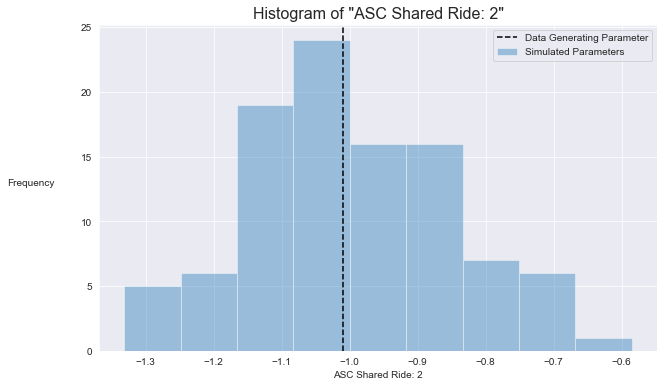

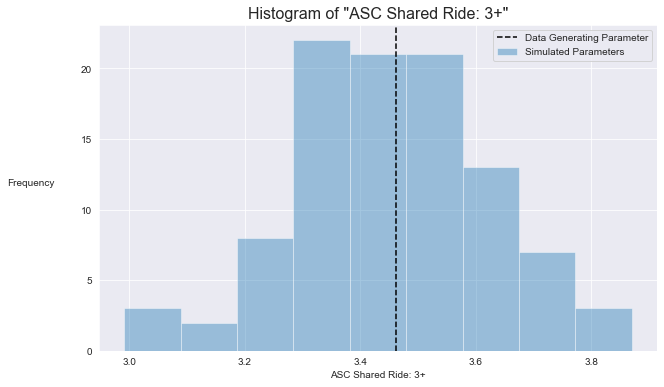

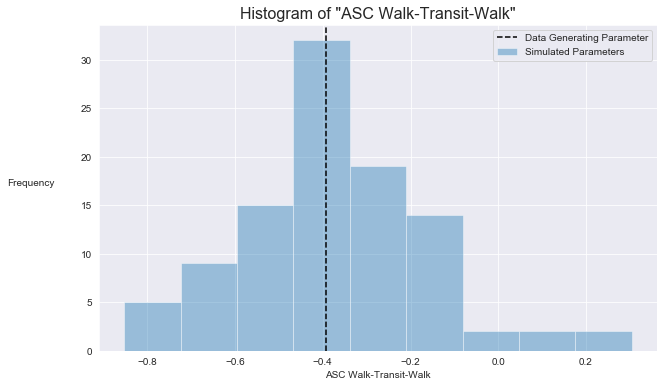

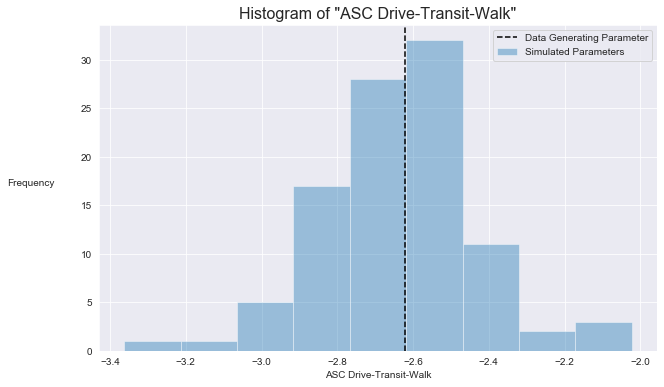

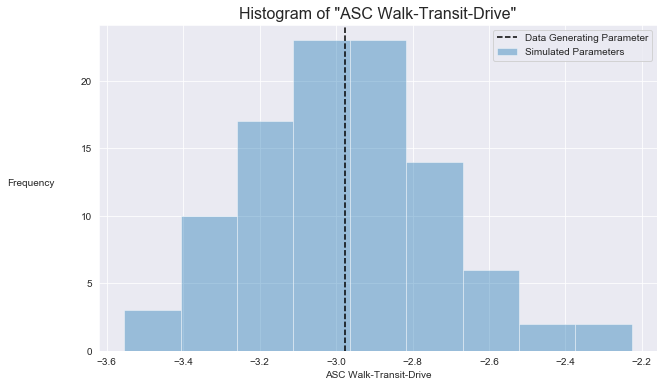

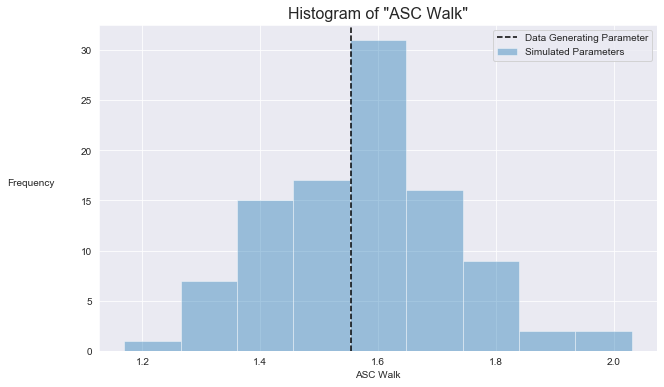

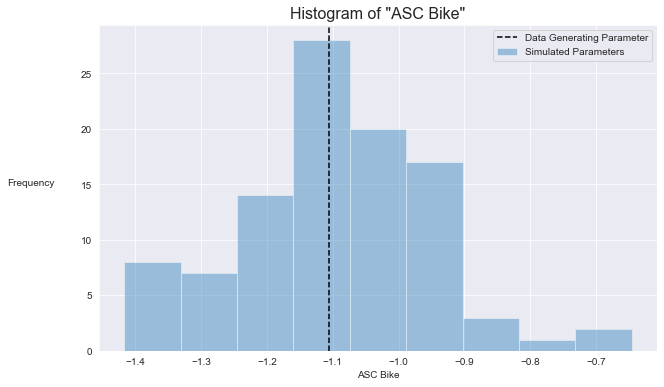

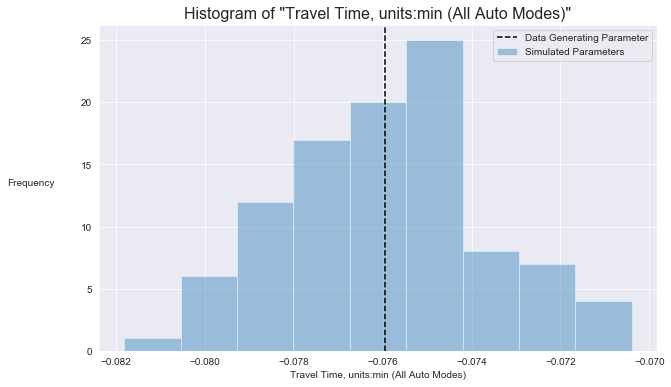

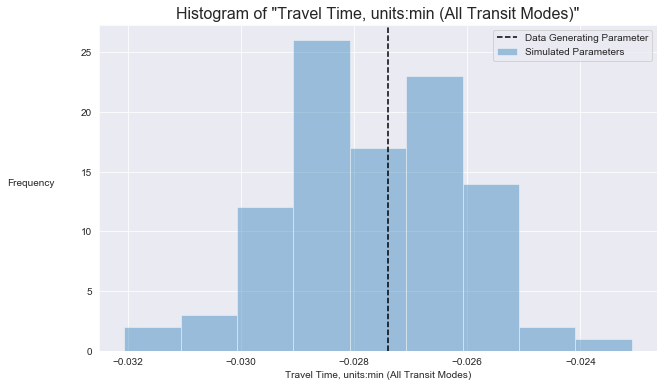

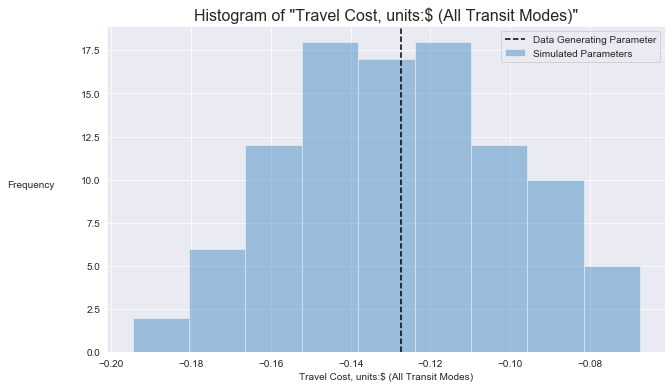

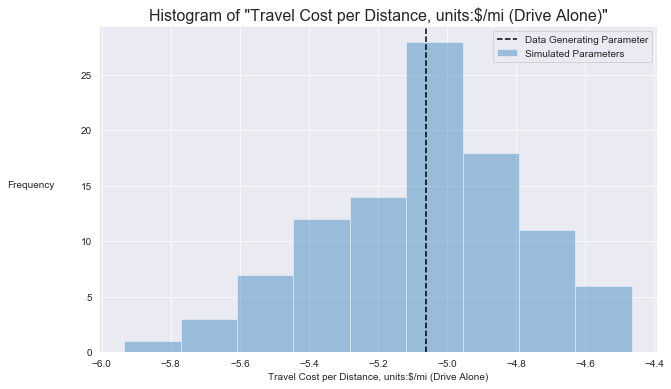

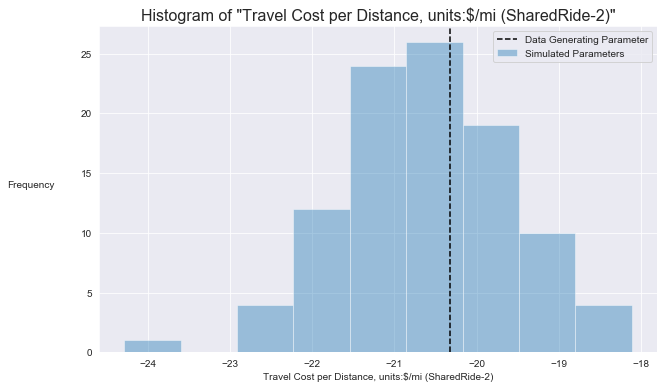

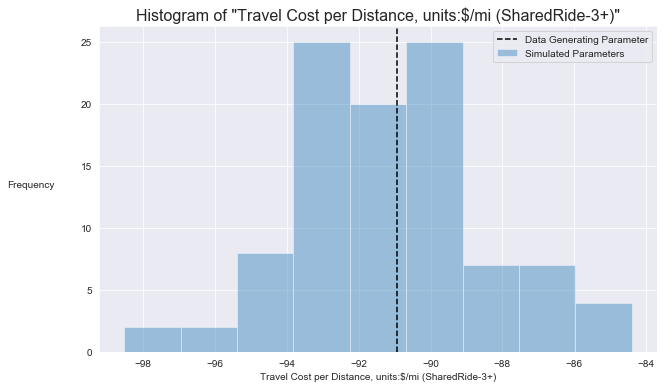

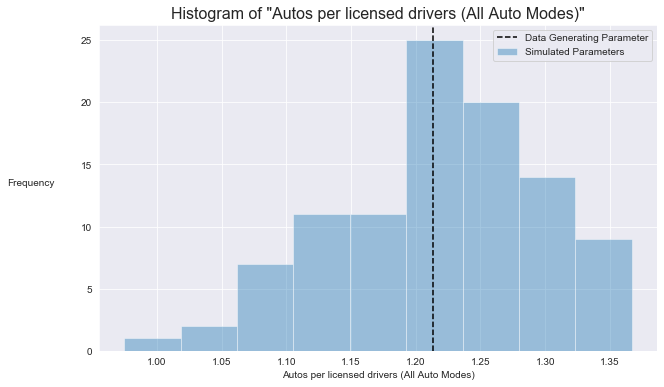

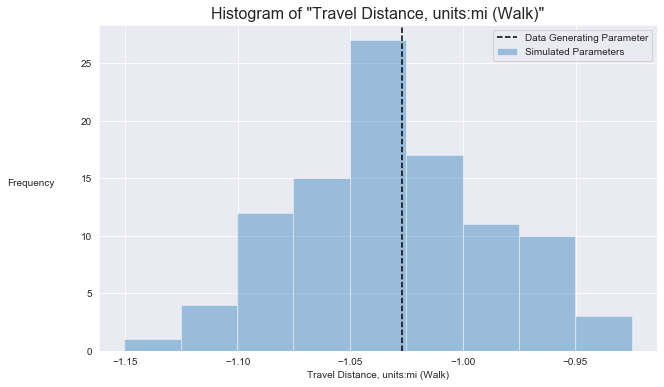

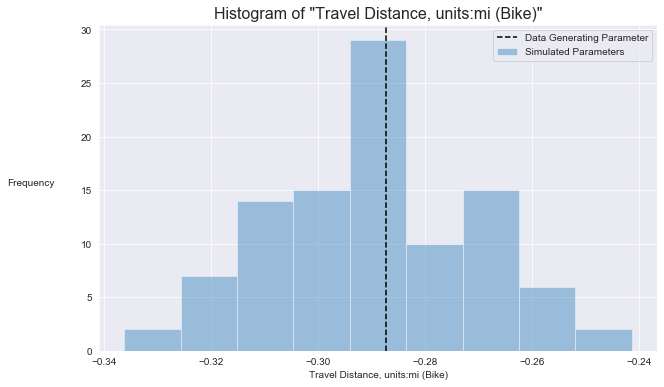

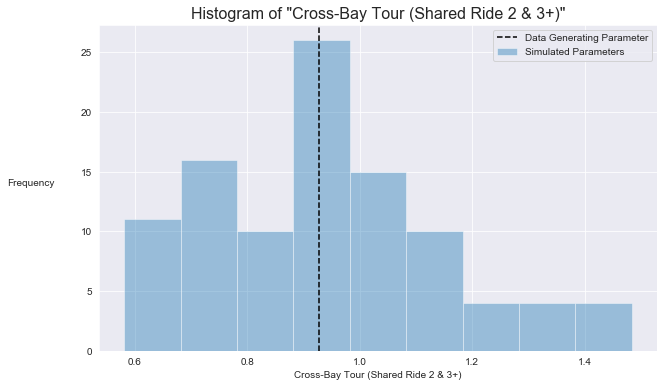

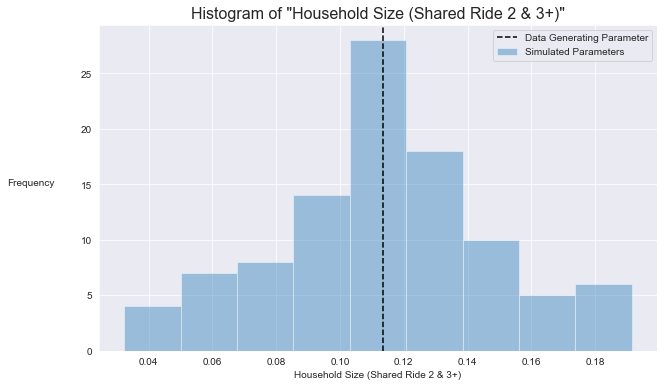

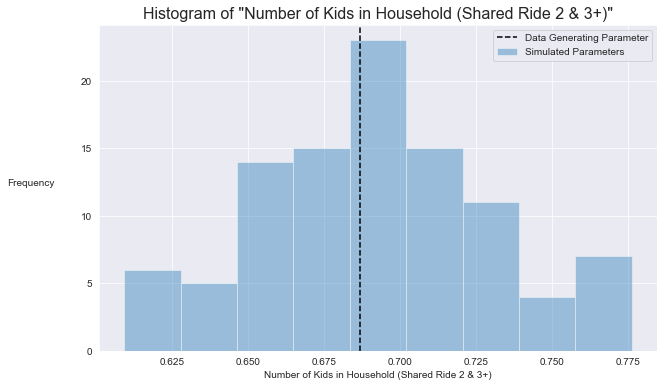

In [41]:
# Loop around the different parameters
# and plot the figures:

for par in sim_estimated_par.columns:
    PlotParams(sim_estimated_par[par],mnl_model, (10,6))

# 9. Sample implementation of outlier removal 

## 9.1 Implementation

This code should be executed before simulating availability and estimating the model

In [218]:
# Initiate a matrix of non outliers
non_outliers_matrix = np.empty((0,wide_sim_data.shape[0]))

# Specify the columns to evaluate for outliers
columns = ['total_travel_time_drive_alone',
          'total_travel_time_shared_2',
          'total_travel_time_shared_3p']

# Loop around columns of Interest
for col in columns:
    non_outliers = FindOutliers(wide_sim_data[col])
    non_outliers_matrix = np.append(non_outliers_matrix, [non_outliers], axis=0)

# Convert the matrix into a dataframe
non_outliers_pd = pd.DataFrame(non_outliers_matrix.T)

# Find observations without outliers
# for any of the columns of interest
non_outlier_obs = non_outliers_pd.all(axis=1)

# Filter non outlier observations
wide_sim_data_clean = wide_sim_data[non_outlier_obs]
wide_sim_data_clean.reset_index(drop=True, inplace=True)

In [220]:
wide_sim_data_clean.head()

,num_kids,household_size,num_cars,num_licensed_drivers,total_travel_time_drive_alone,total_travel_distance_drive_alone,total_travel_cost_drive_alone,total_travel_time_shared_2,total_travel_distance_shared_2,total_travel_cost_shared_2,...,total_travel_time_wtd,total_travel_distance_wtd,total_travel_cost_wtd,total_travel_time_walk,total_travel_distance_walk,total_travel_cost_walk,total_travel_time_bike,total_travel_distance_bike,total_travel_cost_bike,cross_bay
0,0,5.0,2.0,3.0,13.650257,51.506897,5.016416,41.311260,3.594684,0.667758,...,60.725624,0.0,6.095259,245.451332,12.694140,0.0,8.053646,12.214654,0.0,0
1,3,3.0,1.0,2.0,16.422684,9.484117,71.688785,39.457459,2.302416,3.308174,...,144.670509,0.0,2.909781,1365.982937,4.599773,0.0,94.363306,3.620553,0.0,0
2,1,5.0,4.0,2.0,23.808119,0.662526,4.568943,10.075980,4.711111,1.370357,...,72.721801,0.0,4.581889,15.777968,25.519545,0.0,62.014765,14.957864,0.0,0
3,0,2.0,2.0,3.0,10.029874,63.766233,0.311897,14.148222,14.415949,1.303414,...,84.532833,0.0,3.391691,122.314964,42.721478,0.0,11.153831,4.798279,0.0,0
4,0,4.0,2.0,3.0,33.577916,4.451574,0.583919,25.952416,3.478489,1.267106,...,117.072320,0.0,5.515531,162.019498,104.210537,0.0,41.224141,5.219893,0.0,0


## 9.2 Plots 

### Travel Time Drive Alone

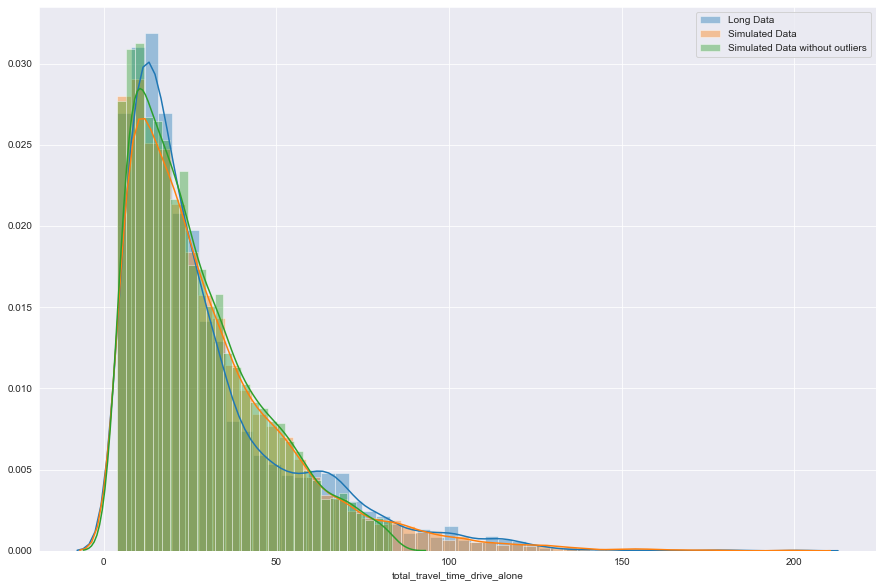

In [233]:
plt.figure(figsize=(15,10))
sns.distplot(bike_data_long.loc[bike_data_long['mode_id']==1]['total_travel_time'], label ='Long Data')
sns.distplot(wide_sim_data['total_travel_time_drive_alone'],label ='Simulated Data')
sns.distplot(wide_sim_data_clean['total_travel_time_drive_alone'],label ='Simulated Data without outliers')
plt.legend()

### Travel Time Shared Ride 2

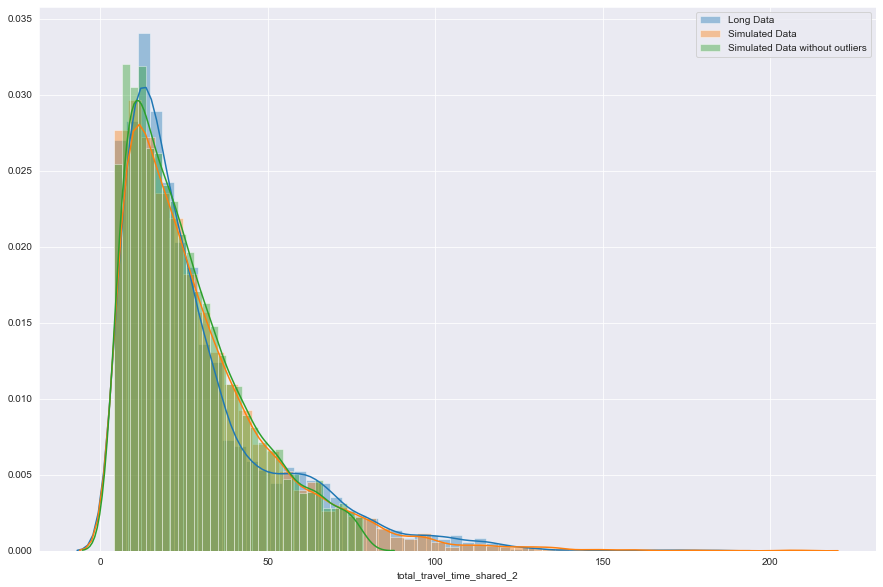

In [234]:
plt.figure(figsize=(15,10))
sns.distplot(bike_data_long.loc[bike_data_long['mode_id']==2]['total_travel_time'], label ='Long Data')
sns.distplot(wide_sim_data['total_travel_time_shared_2'],label ='Simulated Data')
sns.distplot(wide_sim_data_clean['total_travel_time_shared_2'],label ='Simulated Data without outliers')
plt.legend()

### Travel Time Shared Ride 3+

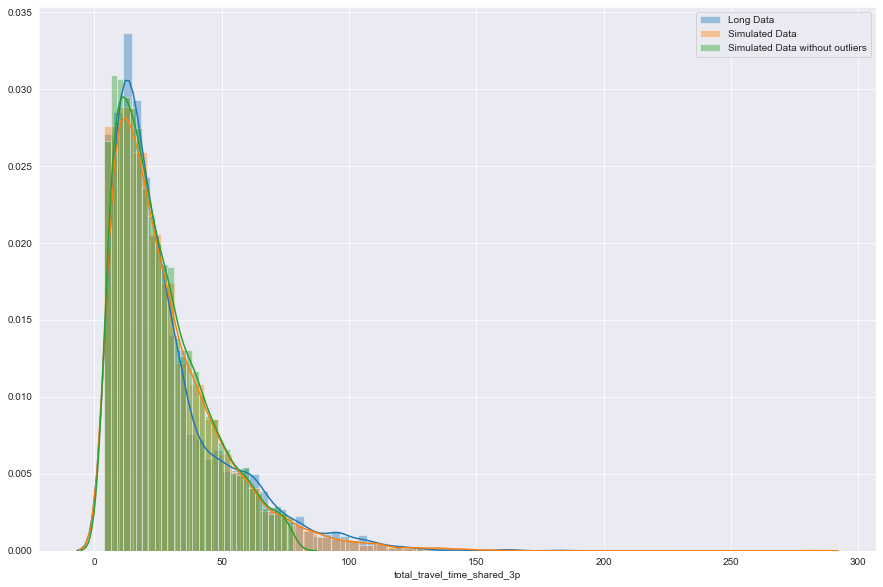

In [235]:
plt.figure(figsize=(15,10))
sns.distplot(bike_data_long.loc[bike_data_long['mode_id']==3]['total_travel_time'], label ='Long Data')
sns.distplot(wide_sim_data['total_travel_time_shared_3p'],label ='Simulated Data')
sns.distplot(wide_sim_data_clean['total_travel_time_shared_3p'],label ='Simulated Data without outliers')
plt.legend()